In [1]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
#
# !git clone https://{TOKEN}@github.com/nicoloalbergoni/DeeplabV3Plus-TF2.git
# %load_ext tensorboard
# %cd ./DeeplabV3Plus-TF2

In [2]:
#!python download_and_prepare_voc.py --remove_cmap --download_berkley

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from superresolution import Superresolution
from model import DeeplabV3Plus
from tqdm import tqdm


from utils import load_image, create_mask, plot_prediction, get_prediction
from superres_utils import get_img_paths, filter_by_class, min_max_normalization, load_images, plot_histogram, print_labels

In [4]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SUPERRES_ROOT = os.path.join(DATA_DIR, "superres_root")
PRECOMPUTED_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "precomputed_features")
STANDARD_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "standard_output")
SUPERRES_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "superres_output")

# SEED = np.random.randint(0, 1000)
SEED = 1234
IMG_SIZE = (512, 512)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True
NUM_AUG = 50
CLASS_ID = 8
NUM_SAMPLES = 300

# Utils Functions

In [5]:
image_list_path = os.path.join(DATA_DIR, "augmented_file_lists", "valaug.txt")
image_paths = get_img_paths(image_list_path, IMGS_PATH)[:NUM_SAMPLES]
images_dict = filter_by_class(image_paths, class_id=CLASS_ID)

print(f"Valid images: {len(images_dict)} (Initial:  {len(image_paths)})")

valid_filenames = list(images_dict.keys())

model_no_upsample = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=False)

model_standard = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=True)

Valid images: 26 (Initial:  300)


# Compute standard output for comparison

In [6]:
def compute_standard_output(image_dict, model, dest_folder, filter_class_id=None):
    standard_masks = {}
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for key in tqdm(image_dict):
        standard_mask = get_prediction(model, image_dict[key])
        if filter_class_id is not None:
            standard_mask = tf.where(standard_mask == filter_class_id, standard_mask, 0) # Set to 0 all predictions different from the given class
        tf.keras.utils.save_img(f"{dest_folder}/{key}.png", standard_mask, scale=False)
        standard_masks[key] = standard_mask

    return standard_masks

In [7]:
standard_masks_dict = compute_standard_output(images_dict, model_standard, dest_folder=STANDARD_OUTPUT_DIR, filter_class_id=CLASS_ID)

100%|██████████| 26/26 [00:07<00:00,  3.70it/s]


# Precompute Augmented Output Features

In [8]:
def augment_image(image, num_aug, angle_max, shift_max):

    batched_images = tf.tile(tf.expand_dims(image, axis=0), [num_aug, 1, 1, 1])  # Size [num_aug, 512, 512, 3]
    angles = np.random.uniform(-angle_max, angle_max, num_aug)
    shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
    # First sample is not augmented
    angles[0] = 0
    shifts[0] = np.array([0, 0])
    angles = angles.astype("float32")
    shifts = shifts.astype("float32")

    rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear")
    translated_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear")

    return translated_images, angles, shifts

def compute_augmented_features(image_filenames, model, dest_folder, filter_class_id=None, num_aug=100, angle_max=0.5, shift_max=30):
    augmented_features = {}
    for filename in tqdm(image_filenames):
        image_path = os.path.join(IMGS_PATH, f"{filename}.jpg")
        image = load_image(image_path, image_size=(512, 512), normalize=True)
        augmented_images, angles, shifts = augment_image(image, num_aug=num_aug, angle_max=angle_max, shift_max=shift_max)

        output_folder= os.path.join(dest_folder, filename)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        predictions = model.predict(augmented_images, batch_size=BATCH_SIZE)

        masks = []
        for i, prediction in enumerate(predictions):
            mask = create_mask(prediction)
            if filter_class_id is not None:
                mask = tf.where(mask == filter_class_id, mask, 0) # Set to 0 all predictions different from the given class

            mask_npy = mask.numpy()
            mask = min_max_normalization(mask_npy, new_min=0.0, new_max=255.0).astype('uint8')

            #mask_scaled = ((mask_npy - mask_npy.min()) * (1/(mask_npy.max() - mask_npy.min()) * 255)).astype('uint8')

            tf.keras.utils.save_img(f"{output_folder}/{i}.png", mask, scale=False)
            np.save(os.path.join(output_folder, f"{filename}_angles"), angles)
            np.save(os.path.join(output_folder, f"{filename}_shifts"), shifts)

            masks.append(mask)

        augmented_features[filename] = masks

    return augmented_features

In [9]:
angle_max = 0.5  # in radians
shift_max = 30

augmented_features_dict = compute_augmented_features(valid_filenames, model_no_upsample, dest_folder=PRECOMPUTED_OUTPUT_DIR, filter_class_id=CLASS_ID, num_aug=NUM_AUG, angle_max=angle_max, shift_max=shift_max)

  4%|▍         | 1/26 [00:06<02:31,  6.05s/it]C:\Users\alber\Desktop\DeeplabV3Plus-TF2\superres_utils.py:54: RuntimeWarning: invalid value encountered in true_divide
  return new_min + (num / den)
100%|██████████| 26/26 [01:42<00:00,  3.95s/it]


# Compute Super-Resolution Output

In [10]:
def compute_superresolution_output(image_filenames, superresolution_obj, precomputed_root_dir, dest_folder, num_aug=100):

    superres_masks = {}
    losses = {}

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for filename in tqdm(image_filenames):
        precomputed_folder_path = os.path.join(precomputed_root_dir, filename)

        if not len(os.listdir(precomputed_folder_path)) == (num_aug + 2):
            print(f"Skipped folder named {filename} as it is not valid")
            continue

        augmented_images = tf.stack(load_images(precomputed_folder_path))
        max_values = np.max(augmented_images, axis=(1, 2, 3), keepdims=True)
        max_values[max_values == 0.] = 1.
        augmented_images = augmented_images / max_values
        augmented_images = tf.cast(augmented_images, tf.float32)

        base_name = os.path.basename(os.path.normpath(precomputed_folder_path))
        angles = np.load(os.path.join(precomputed_folder_path, f"{base_name}_angles.npy"))
        shifts = np.load(os.path.join(precomputed_folder_path, f"{base_name}_shifts.npy"))

        target_image, loss = superresolution_obj.compute_output(augmented_images, angles, shifts)
        target_image = target_image[0]

        target_image_npy = target_image.numpy()
        #target_image_scaled = ((target_image_npy - target_image_npy.min()) * (1/(target_image_npy.max() - target_image_npy.min()) * 255)).astype('uint8')
        target_image_scaled = min_max_normalization(target_image_npy, new_min=0.0, new_max=255.0).astype('uint8')

        tf.keras.utils.save_img(f"{dest_folder}/{base_name}.png", target_image_scaled, scale=False)

        superres_masks[base_name] = target_image_scaled
        losses[base_name] = loss

    return superres_masks, losses

In [11]:
# super resolution parameters
learning_rate = 1e-3
lambda_eng = 0.0001 * NUM_AUG
lambda_tv = 0.002 * NUM_AUG
num_iter = 400

superresolution = Superresolution(
    lambda_tv=lambda_tv,
    lambda_eng=lambda_eng,
    num_iter=num_iter,
    num_aug=NUM_AUG,
    learning_rate=learning_rate,
    verbose=False
)

superres_masks_dict, losses = compute_superresolution_output(valid_filenames, superresolution, precomputed_root_dir=PRECOMPUTED_OUTPUT_DIR, dest_folder=SUPERRES_OUTPUT_DIR, num_aug=NUM_AUG)

superres_masks_dict_th = {}

for key in superres_masks_dict:
    sample_th = tf.cast(tf.reduce_max(superres_masks_dict[key]), tf.float32) * 0.15
    th_mask = tf.where(superres_masks_dict[key] > sample_th, CLASS_ID, 0)
    superres_masks_dict_th[key] = th_mask

  4%|▍         | 1/26 [00:17<07:16, 17.47s/it]

Final loss: 17906.783203125


  8%|▊         | 2/26 [00:33<06:37, 16.54s/it]

Final loss: 9648.2822265625


 12%|█▏        | 3/26 [00:49<06:18, 16.45s/it]

Final loss: 18243.3515625


 15%|█▌        | 4/26 [01:05<05:52, 16.04s/it]

Final loss: 5970.93701171875


 19%|█▉        | 5/26 [01:20<05:29, 15.71s/it]

Final loss: 16987.8203125


 23%|██▎       | 6/26 [01:35<05:09, 15.49s/it]

Final loss: 16559.326171875


 27%|██▋       | 7/26 [01:50<04:52, 15.40s/it]

Final loss: 34344.5234375


 31%|███       | 8/26 [02:05<04:36, 15.35s/it]

Final loss: 16151.685546875


 35%|███▍      | 9/26 [02:20<04:19, 15.27s/it]

Final loss: 10552.595703125


 38%|███▊      | 10/26 [02:35<04:03, 15.23s/it]

Final loss: 8708.9091796875


 42%|████▏     | 11/26 [02:51<03:48, 15.24s/it]

Final loss: 14278.310546875


 46%|████▌     | 12/26 [03:06<03:33, 15.23s/it]

Final loss: 4339.54345703125


 50%|█████     | 13/26 [03:21<03:17, 15.20s/it]

Final loss: 19110.736328125


 54%|█████▍    | 14/26 [03:36<03:02, 15.21s/it]

Final loss: 6741.521484375


 58%|█████▊    | 15/26 [03:52<02:47, 15.23s/it]

Final loss: 67448.5546875


 62%|██████▏   | 16/26 [04:07<02:31, 15.19s/it]

Final loss: 75858.9609375


 65%|██████▌   | 17/26 [04:22<02:16, 15.16s/it]

Final loss: 29675.84765625


 69%|██████▉   | 18/26 [04:37<02:00, 15.10s/it]

Final loss: 13773.4775390625


 73%|███████▎  | 19/26 [04:52<01:46, 15.28s/it]

Final loss: 1609.9613037109375


 77%|███████▋  | 20/26 [05:08<01:31, 15.22s/it]

Final loss: 25096.263671875


 81%|████████  | 21/26 [05:23<01:15, 15.20s/it]

Final loss: 378.89202880859375


 85%|████████▍ | 22/26 [05:38<01:00, 15.17s/it]

Final loss: 22655.146484375


 88%|████████▊ | 23/26 [05:53<00:45, 15.14s/it]

Final loss: 978.3121948242188


 92%|█████████▏| 24/26 [06:08<00:30, 15.08s/it]

Final loss: 35896.20703125


 96%|█████████▌| 25/26 [06:23<00:15, 15.07s/it]

Final loss: 10170.345703125


100%|██████████| 26/26 [06:38<00:00, 15.32s/it]

Final loss: 11882.9306640625


# Evaluation

In [12]:
def custom_IOU(y_true, y_pred, class_id):
    y_true_squeeze = tf.squeeze(y_true)
    y_pred_squeeze = tf.squeeze(y_pred)
    classes = [0, class_id] # Only check in background and given class

    y_true_squeeze = tf.where(y_true_squeeze != class_id, 0, y_true_squeeze)

    ious = []
    for i in classes:
        true_labels = tf.equal(y_true_squeeze, i)
        pred_labels = tf.equal(y_pred_squeeze, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)

        iou = tf.reduce_sum(inter) / tf.reduce_sum(union)
        ious.append(iou)

    ious = tf.stack(ious)
    legal_labels = ~tf.math.is_nan(ious)
    ious = tf.gather(ious, indices=tf.where(legal_labels))
    return tf.reduce_mean(ious)


def evaluate_IOU(true_mask, standard_mask, superres_mask, img_size=(512, 512)):
    true_mask = tf.reshape(true_mask, (img_size[0] * img_size[1], 1))
    standard_mask = tf.reshape(standard_mask, (img_size[0] * img_size[1], 1))
    superres_mask = tf.reshape(superres_mask, (img_size[0] * img_size[1], 1))

    # standard_IOU = Mean_IOU(true_mask, standard_mask)
    # superres_IOU = Mean_IOU(true_mask, superres_mask)

    standard_IOU = custom_IOU(true_mask, standard_mask, class_id=CLASS_ID)
    superres_IOU = custom_IOU(true_mask, superres_mask, class_id=CLASS_ID)

    return standard_IOU.numpy(), superres_IOU.numpy()

def compare_results(image_dict, standard_dict, superres_dict, image_size=(512, 512)):
    standard_IOUs = []
    superres_IOUs = []

    for key in image_dict:
        true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{key}.png")
        true_mask = load_image(true_mask_path, image_size=image_size, normalize=False,
                               is_png=True, resize_method="nearest")

        standard_mask = standard_dict[key]
        superres_image = superres_dict[key]

        standard_IOU, superres_IOU = evaluate_IOU(true_mask, standard_mask, superres_image, img_size=image_size)
        standard_IOUs.append(standard_IOU)
        superres_IOUs.append(superres_IOU)
        print(f"IOUs for image {key} - Standard: {str(standard_IOU)}, Superres: {str(superres_IOU)}")

    return standard_IOUs, superres_IOUs

In [13]:
standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th, image_size=IMG_SIZE)

IOUs for image 2008_002152 - Standard: 0.9085044608441453, Superres: 0.8838538982083478
IOUs for image 2007_008815 - Standard: 0.8569716559605662, Superres: 0.8692949182623165
IOUs for image 2008_000345 - Standard: 0.9379868804976746, Superres: 0.9286472716071725
IOUs for image 2010_005421 - Standard: 0.8882681156496353, Superres: 0.8758326186487495
IOUs for image 2010_002531 - Standard: 0.9380899481960936, Superres: 0.9206306939823423
IOUs for image 2010_001351 - Standard: 0.9413018640887326, Superres: 0.9244617061136173
IOUs for image 2010_002025 - Standard: 0.9285347152054473, Superres: 0.9141153947837337
IOUs for image 2011_000661 - Standard: 0.8515296926500249, Superres: 0.7910586997880567
IOUs for image 2009_000080 - Standard: 0.9089036926950496, Superres: 0.8681612413049719
IOUs for image 2010_000724 - Standard: 0.7795417381062342, Superres: 0.7789430453151279
IOUs for image 2007_009346 - Standard: 0.918779741187651, Superres: 0.9081940547159411
IOUs for image 2010_001913 - Stan

In [14]:
print(f"Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.819589822214711


# Tests

In [15]:
def plot_standard_superres(input_image, ground_truth, standard_mask, superres_mask):
    plt.figure(figsize=(18, 18))

    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ground_truth), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Sandard predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(standard_mask), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superresolution Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(superres_mask), alpha=0.5)
    plt.axis('off')


    plt.show()

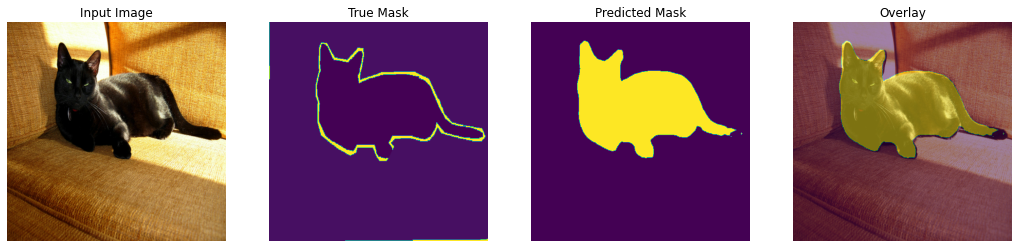

Standard Labels: {8.0: 48980, 18.0: 205278, 255.0: 7886}
Superres Labels: {0: 210713, 8: 51431}


In [16]:
sample_key = random.choice(valid_filenames)
sample_image = images_dict[sample_key]
sample_standard = standard_masks_dict[sample_key]
sample_superres = superres_masks_dict[sample_key]
sample_superres_th = superres_masks_dict_th[sample_key]

true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{sample_key}.png")
true_mask = load_image(true_mask_path, image_size=IMG_SIZE, normalize=False, is_png=True, resize_method="nearest")

plot_prediction([sample_image, true_mask, sample_standard], only_prediction=False, show_overlay=True)
print_labels([true_mask, sample_standard])

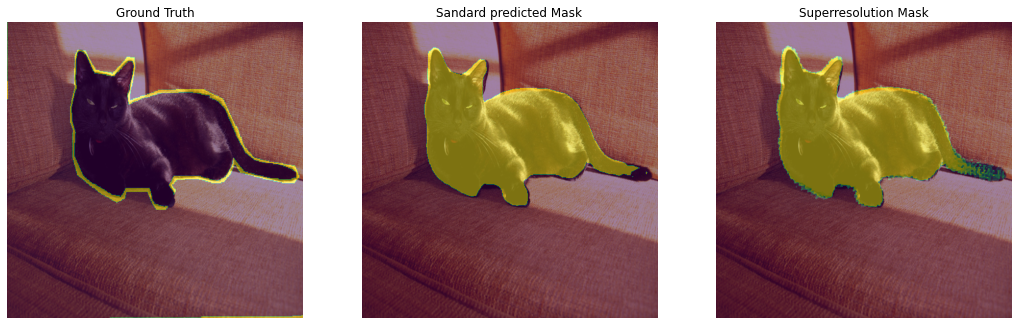

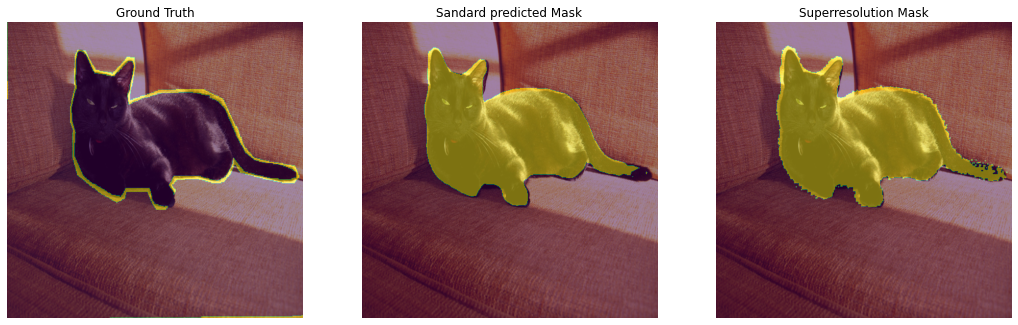

(0.9380899481960936, 0.9206306939823423)

In [17]:
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres)
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres_th)
evaluate_IOU(true_mask, sample_standard, sample_superres_th)

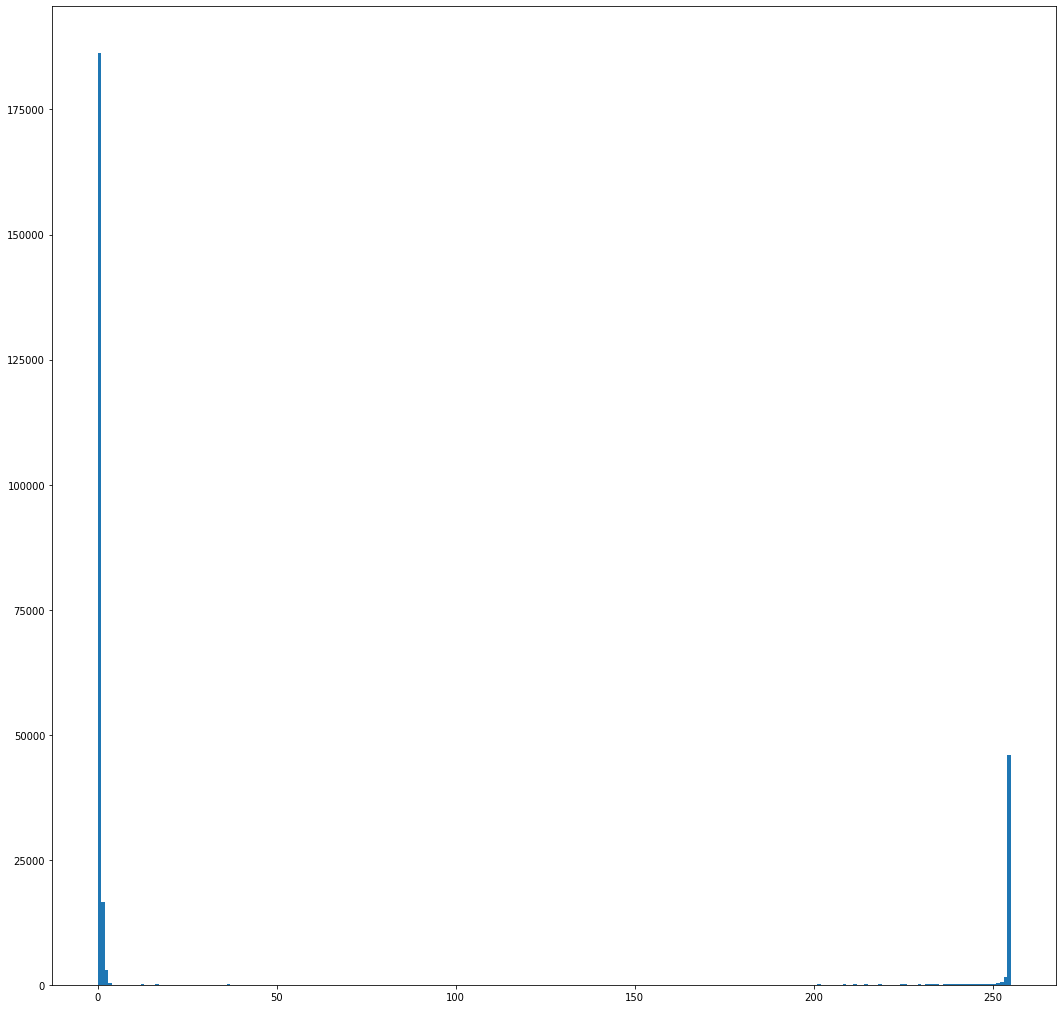

In [18]:
plot_histogram(sample_superres)

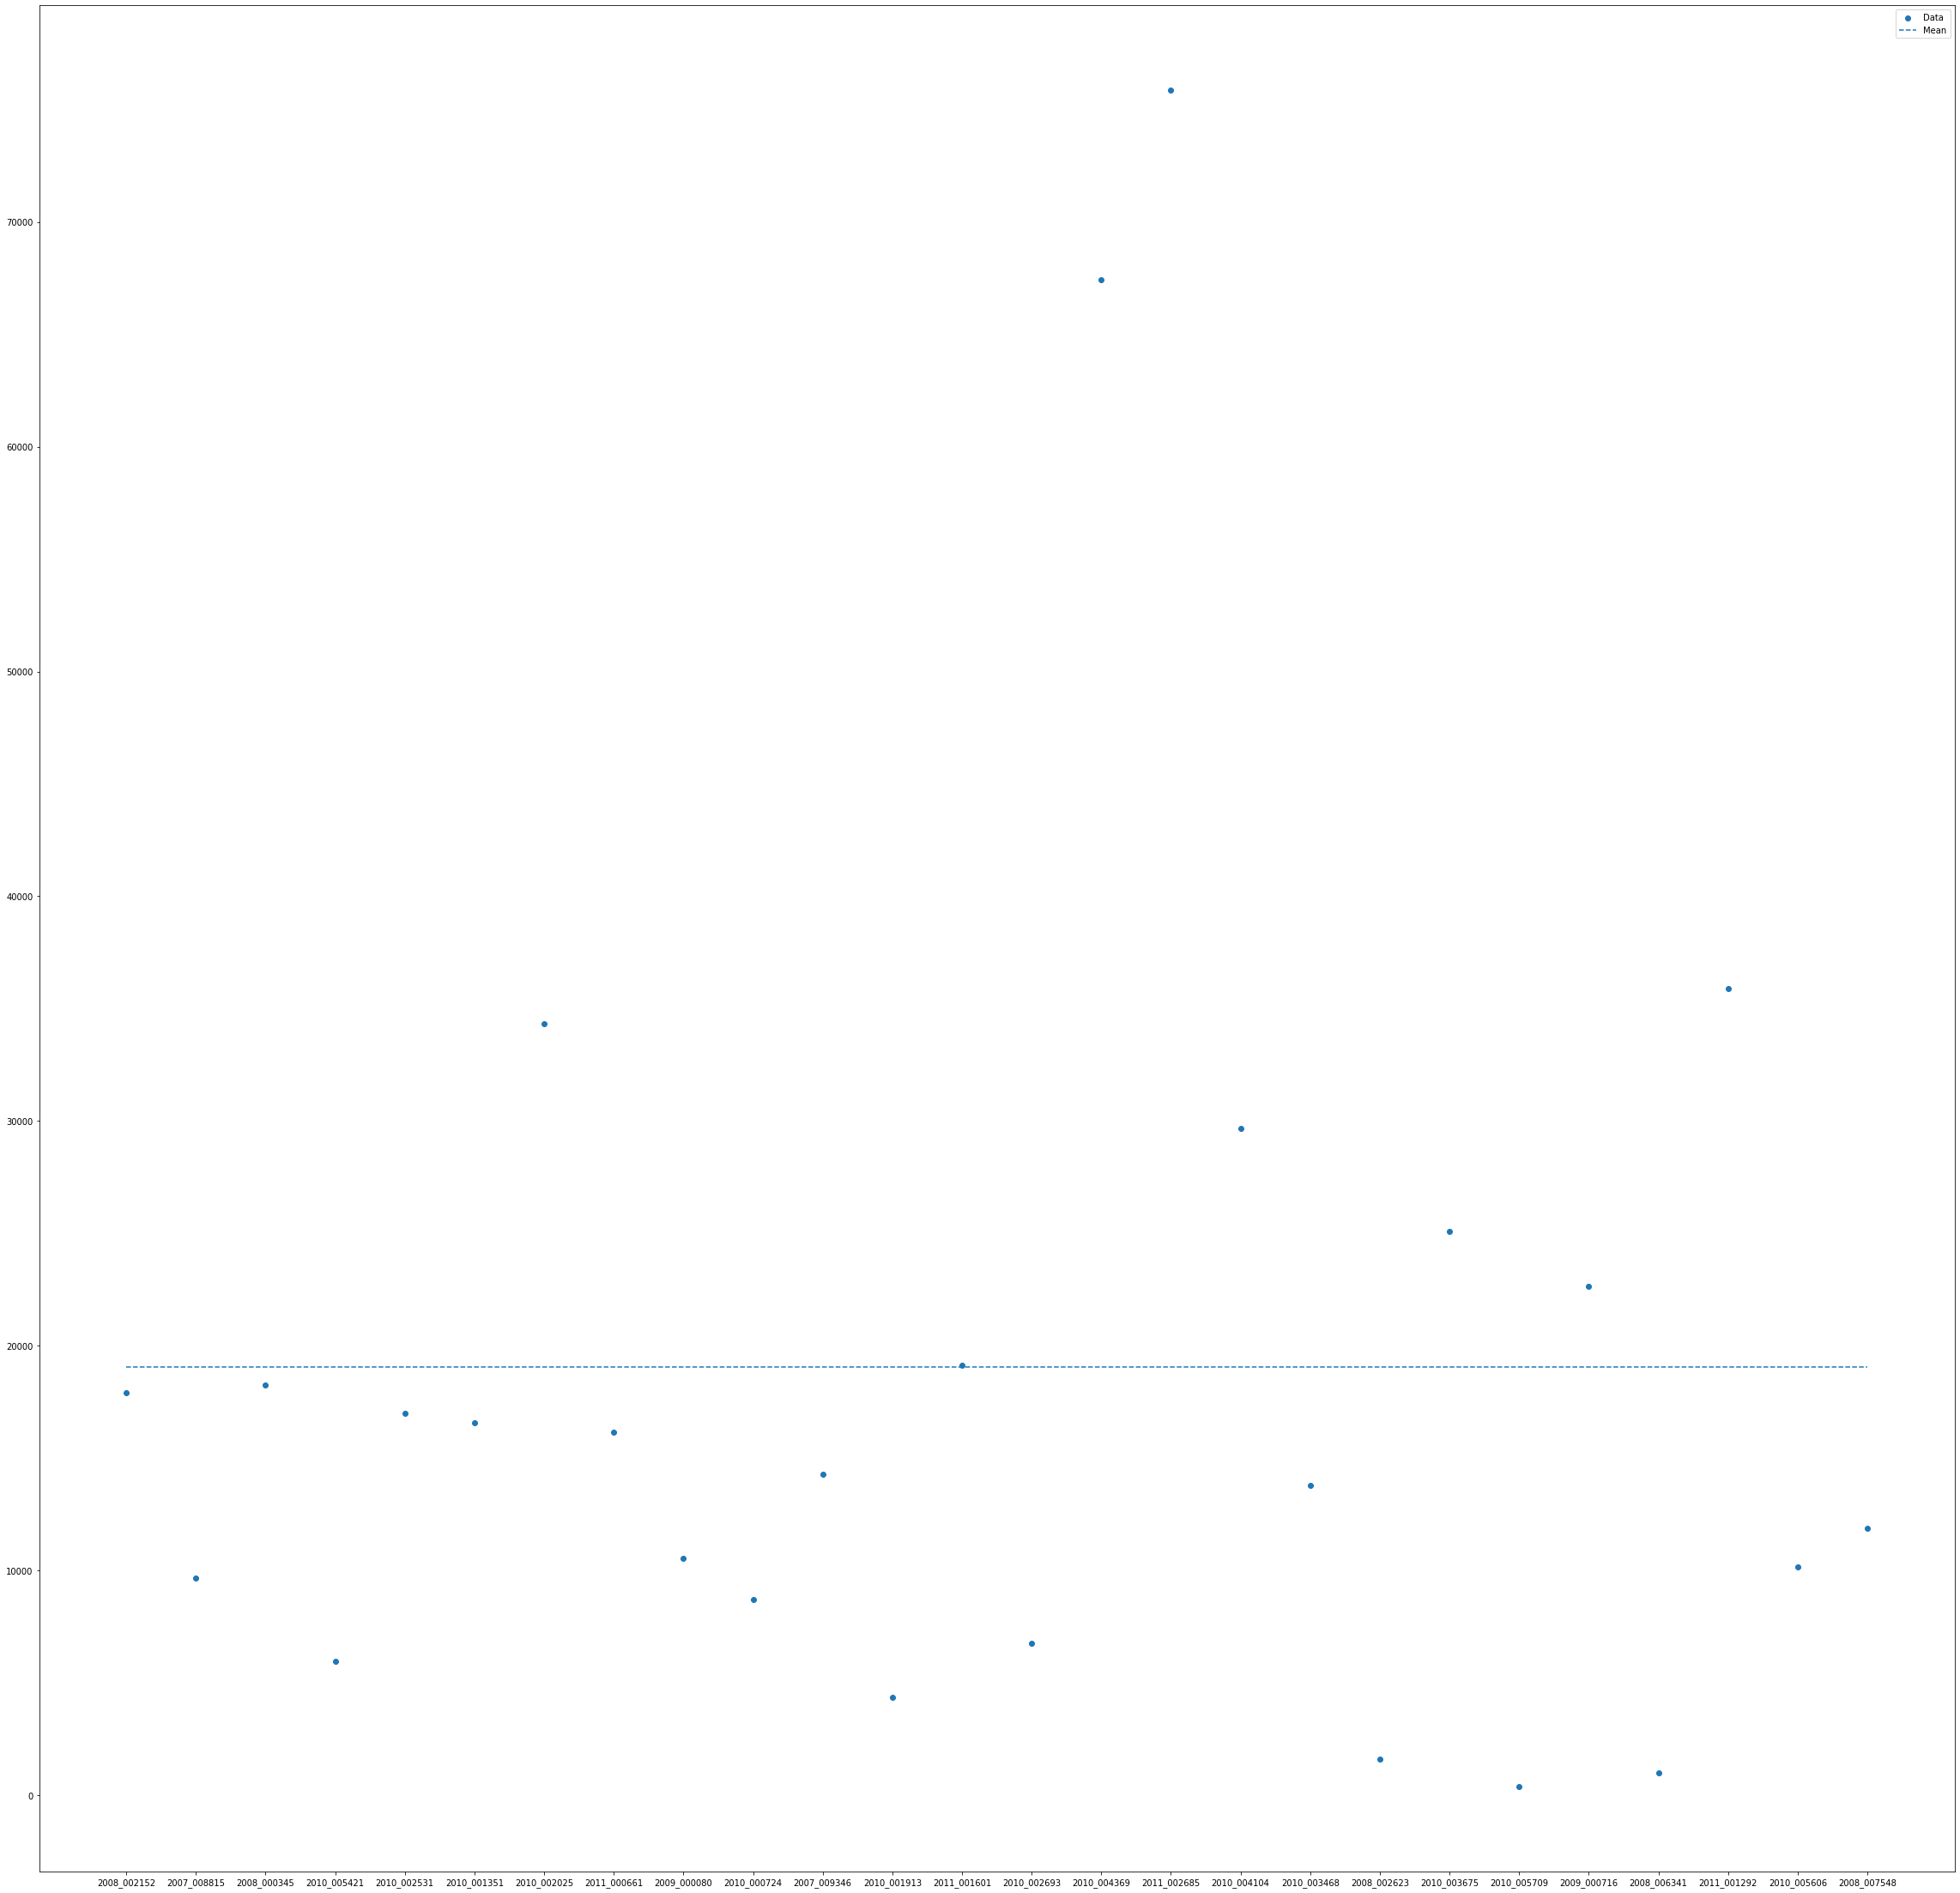

In [19]:
keys = list(losses.keys())
values = list(losses.values())
mean = [np.mean(values)] * len(values)

fig, ax = plt.subplots(figsize=(40, 40))

# Plot the data
data_line = ax.scatter(keys, values, label='Data', marker='o')

# Plot the average line
mean_line = ax.plot(keys, mean, label='Mean', linestyle='--')

# Make a legend
legend = ax.legend(loc='upper right')

plt.show()